C:\Users\xedze\AppData\Local\Temp\ipykernel_10096\2227458627.py:392: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax8.legend()


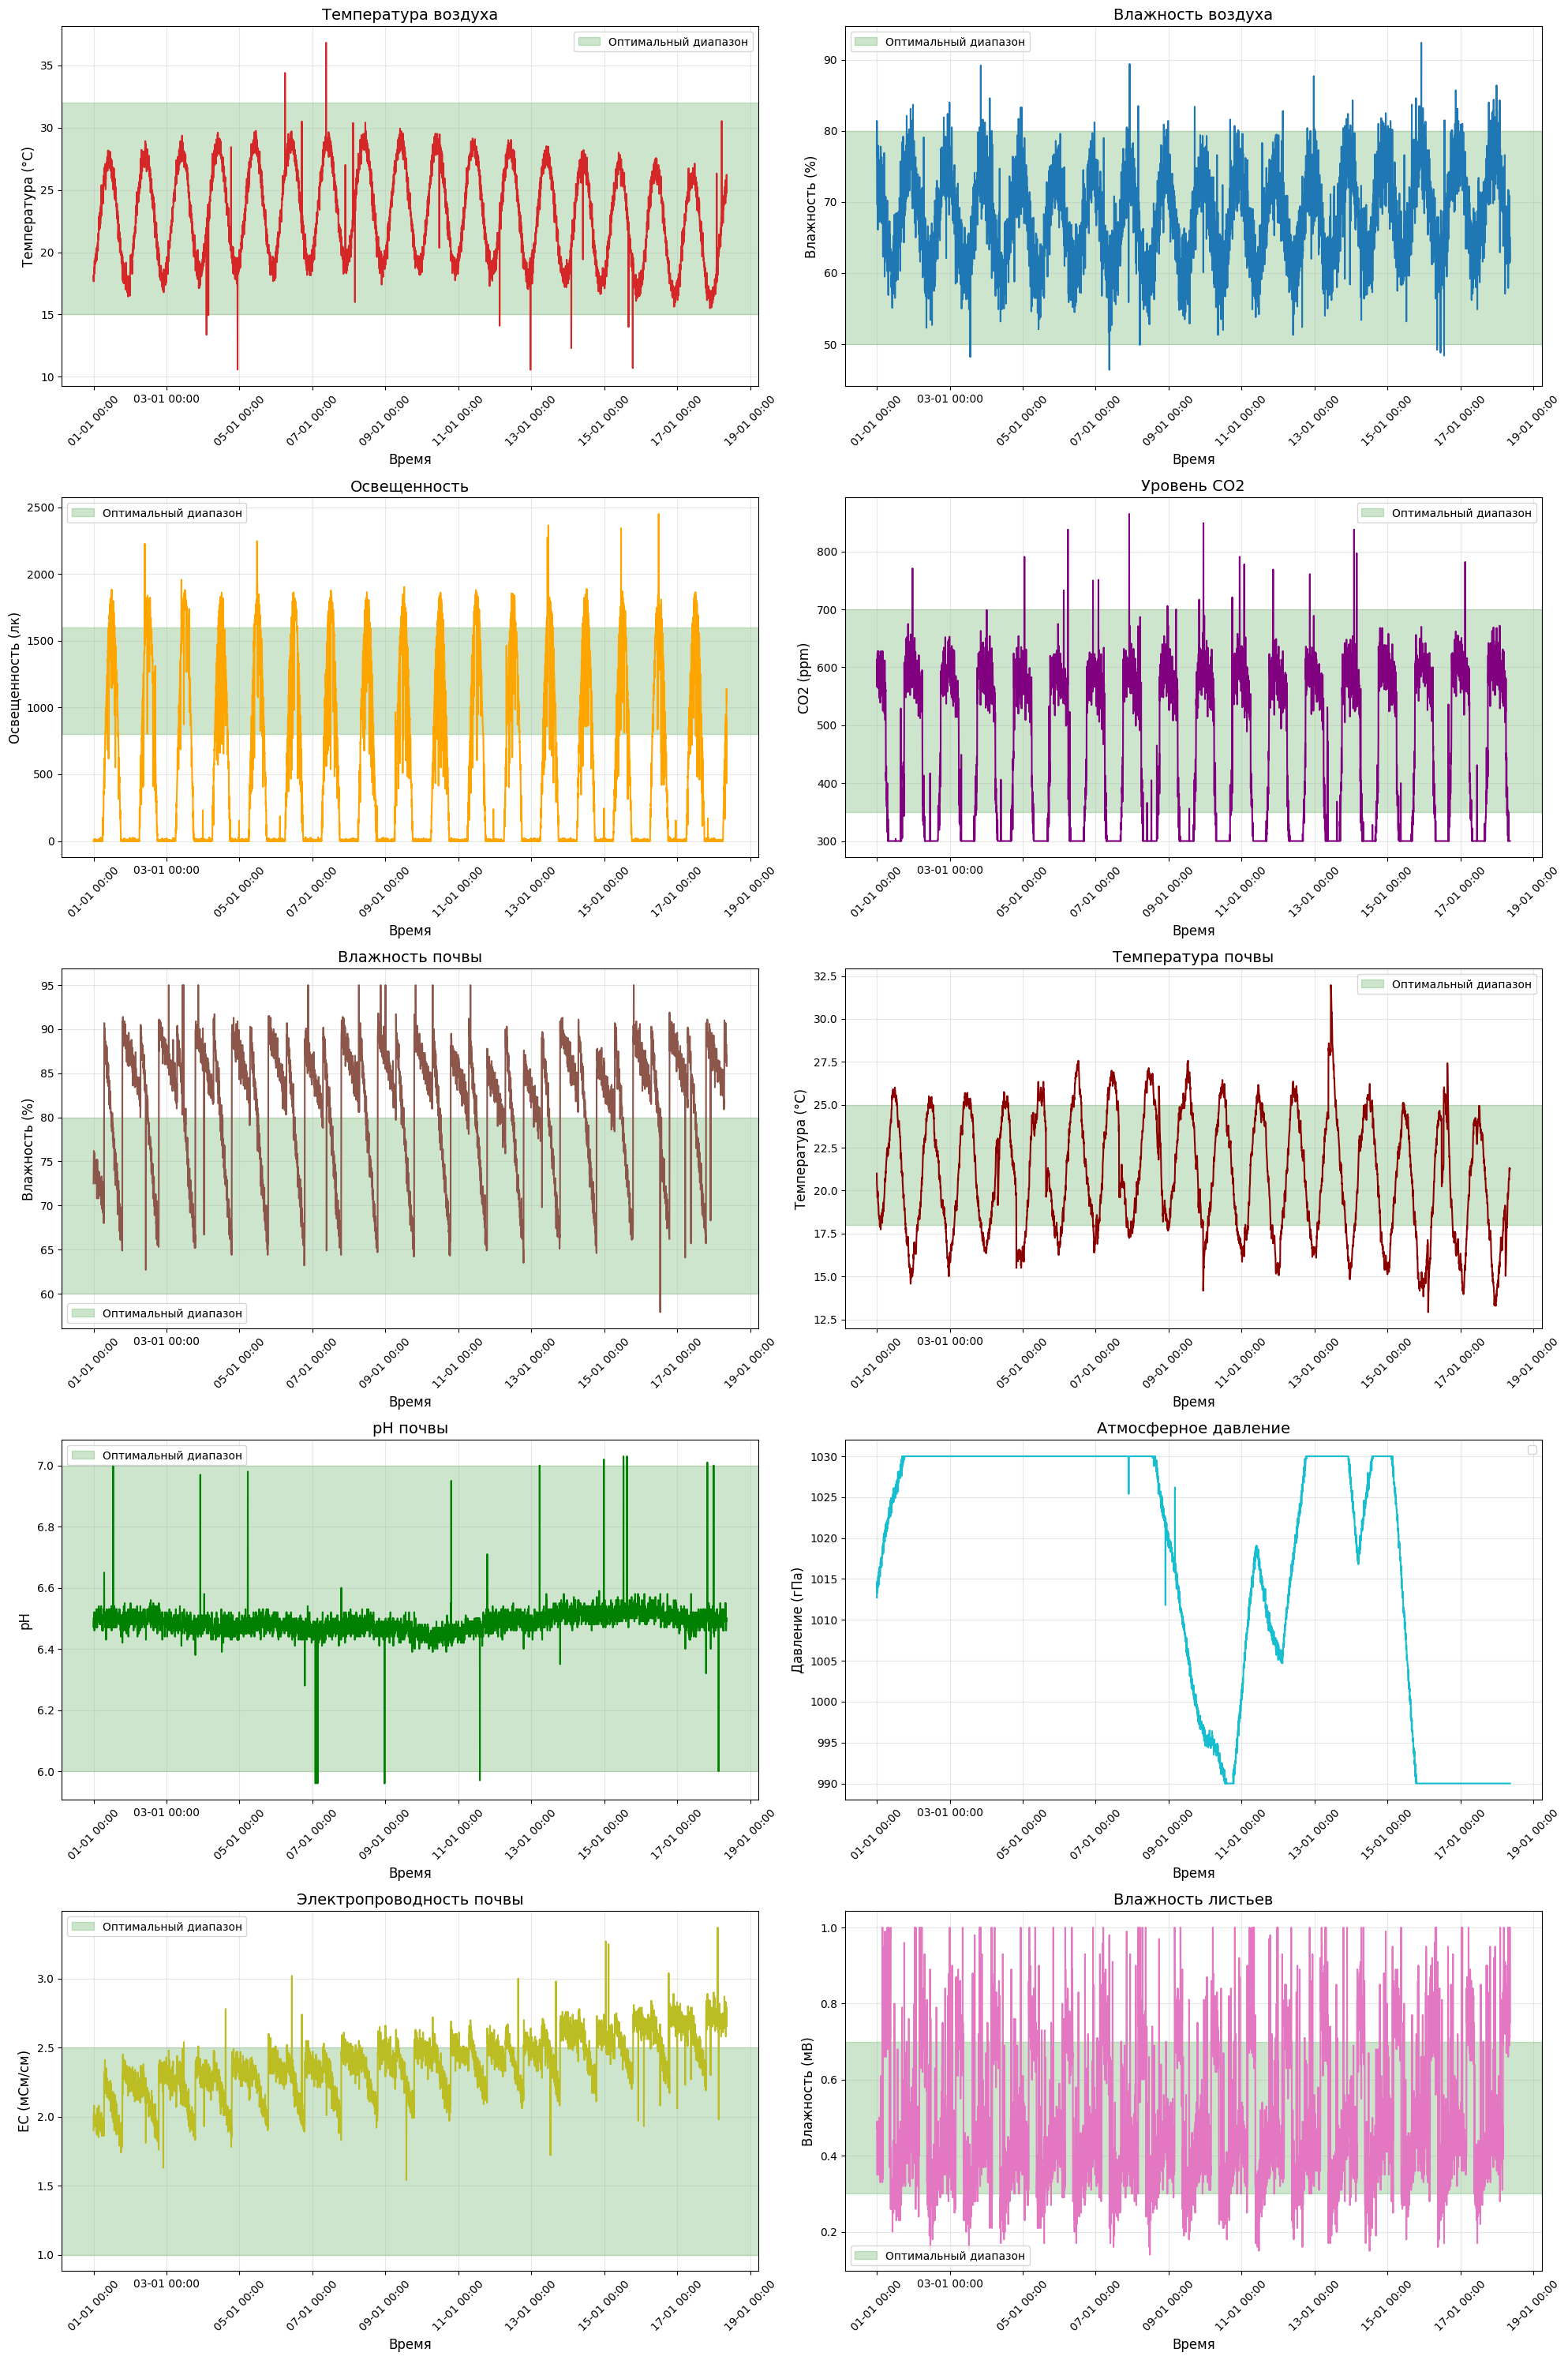

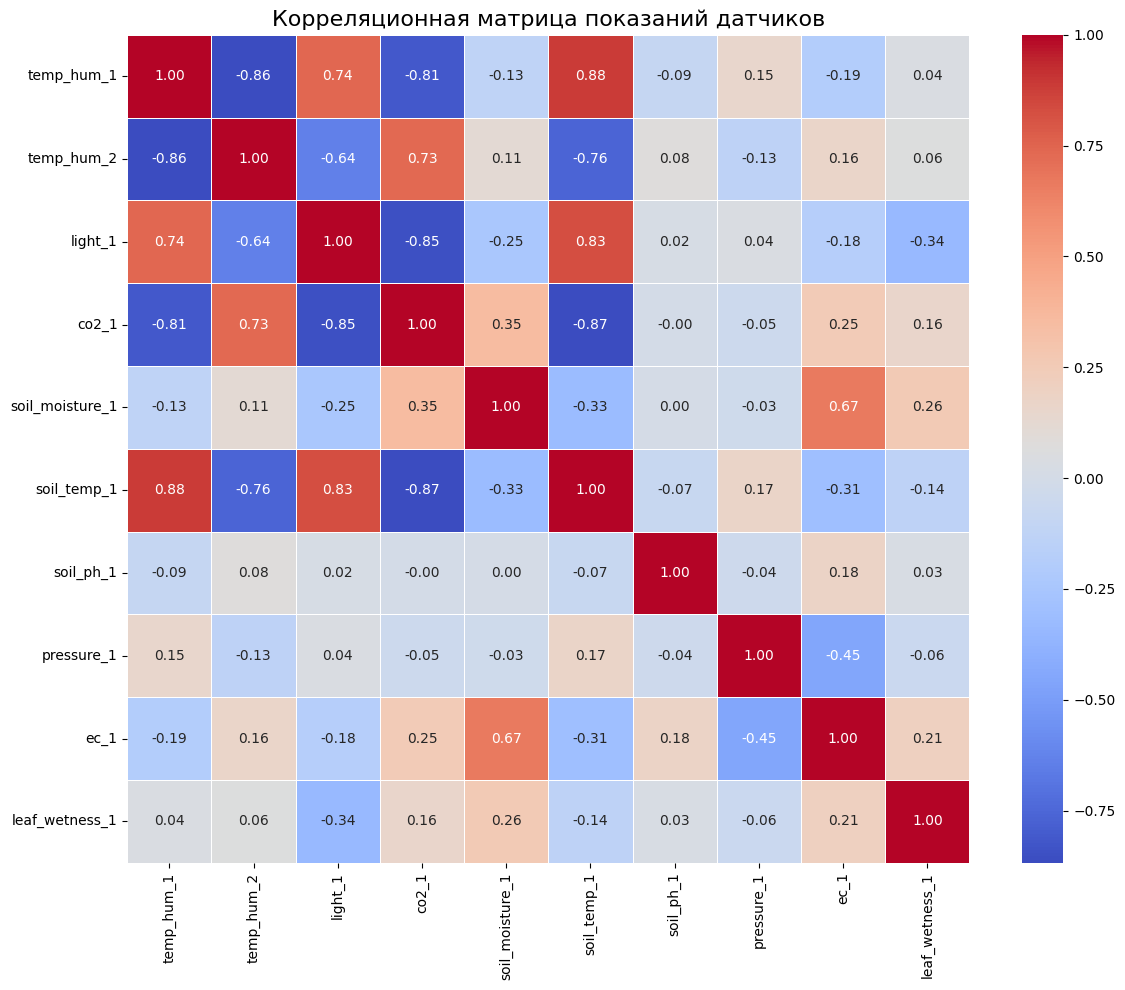

Корреляционная матрица сохранена в correlation_matrix.png


In [2]:
import numpy as np
import pandas as pd
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Характеристики датчиков с реалистичными параметрами
sensor_characteristics = {
    "temp_hum_1": {"mean": 25, "std": 2, "unit": "°C", "min": 15, "max": 35},
    "temp_hum_2": {"mean": 60, "std": 5, "unit": "%", "min": 40, "max": 90},
    "light_1": {"mean": 1200, "std": 200, "unit": "лк", "min": 0, "max": 2000},
    "co2_1": {"mean": 400, "std": 50, "unit": "ppm", "min": 300, "max": 800},
    "soil_moisture_1": {"mean": 70, "std": 10, "unit": "%", "min": 40, "max": 90},
    "soil_temp_1": {"mean": 22, "std": 1, "unit": "°C", "min": 18, "max": 28},
    "soil_ph_1": {"mean": 6.5, "std": 0.2, "unit": "pH", "min": 5.5, "max": 7.5},
    "pressure_1": {"mean": 1013, "std": 5, "unit": "гПа", "min": 990, "max": 1030},
    "ec_1": {"mean": 1.5, "std": 0.3, "unit": "мСм/см", "min": 0.8, "max": 3.0},
    "leaf_wetness_1": {"mean": 0.5, "std": 0.1, "unit": "мВ", "min": 0, "max": 1.0}
}

# Генерация временных меток
start_time = datetime(2025, 1, 1)
timestamps = [start_time + timedelta(minutes=5 * i) for i in range(5000)]

# Подготовка данных для DataFrame
data_dict = {"timestamp": timestamps}

# Генерация синтетических данных с реалистичными закономерностями
# Температура воздуха: дневной цикл с шумом
temps = []
for timestamp in timestamps:
    hour = timestamp.hour + timestamp.minute / 60
    # Дневной цикл: минимум ночью (около 4:00), максимум днем (около 15:00)
    day_cycle = np.sin((hour - 4) * 2 * np.pi / 24)
    base_temp = 22 + 5 * day_cycle  # Базовая температура с размахом ±5°C
    # Добавление медленно меняющегося тренда (имитация погодных изменений)
    day_of_year = timestamp.timetuple().tm_yday
    weather_trend = 2 * np.sin(2 * np.pi * day_of_year / 30)  # Месячный цикл
    # Добавление случайного шума
    noise = np.random.normal(0, 0.5)
    # Редкие выбросы (неисправности датчика)
    if np.random.rand() < 0.005:  # 0.5% вероятность
        noise = np.random.choice([-8, 8])
    temp = base_temp + weather_trend + noise
    temps.append(round(temp, 2))
data_dict["temp_hum_1"] = temps

# Влажность воздуха: обратно коррелирует с температурой + свой шум
humidity = []
for i, temp in enumerate(temps):
    # Обратная зависимость от температуры
    base_hum = 80 - (temp - 15) * 1.5  # При 15°C будет ~80%, при 35°C ~50%
    # Случайные колебания
    noise = np.random.normal(0, 3)
    # Редкие выбросы
    if np.random.rand() < 0.005:
        noise = np.random.choice([-15, 15])
    hum = base_hum + noise
    # Ограничение в пределах 30-95%
    hum = min(95, max(30, hum))
    humidity.append(round(hum, 1))
data_dict["temp_hum_2"] = humidity

# Освещенность: дневной цикл, ночью близка к нулю
light = []
for timestamp in timestamps:
    hour = timestamp.hour + timestamp.minute / 60
    # Дневной цикл: 0 ночью, максимум в полдень
    if 6 <= hour <= 18:  # День с 6:00 до 18:00
        day_cycle = np.sin((hour - 6) * np.pi / 12)  # Максимум в полдень
        base_light = 1800 * day_cycle  # Максимальное значение при ярком свете
    else:
        base_light = 0  # Ночью темно
    
    # Добавление облачности (случайные снижения освещенности)
    cloud_factor = 1
    if np.random.rand() < 0.1 and base_light > 0:
        cloud_factor = np.random.uniform(0.3, 0.8)
    
    # Добавление случайного шума
    noise = np.random.normal(0, 50) if base_light > 0 else np.random.normal(0, 10)
    
    # Редкие выбросы (неисправности датчика или вспышки света)
    if np.random.rand() < 0.005:
        if base_light > 0:
            noise = np.random.uniform(400, 800)
        else:
            noise = np.random.uniform(100, 300)  # Ночное освещение
    
    lux = base_light * cloud_factor + noise
    lux = max(0, lux)  # Не может быть отрицательным
    light.append(round(lux, 0))
data_dict["light_1"] = light

# CO2: увеличивается ночью, понижается днем (фотосинтез), зависимость от влажности
co2 = []
for i, timestamp in enumerate(timestamps):
    hour = timestamp.hour + timestamp.minute / 60
    # Дневной цикл (инвертированный по отношению к свету)
    if 6 <= hour <= 18:  # День
        day_cycle = 1 - 0.7 * np.sin((hour - 6) * np.pi / 12)
    else:  # Ночь
        day_cycle = 1.3
    
    # Базовое значение CO2 с учетом цикла
    base_co2 = 400 * day_cycle
    
    # Зависимость от влажности (влажность может влиять на вентиляцию)
    hum_factor = 1 + (humidity[i] - 60) / 100
    
    # Добавление случайного шума
    noise = np.random.normal(0, 20)
    
    # Редкие выбросы (открытие двери, деятельность людей)
    if np.random.rand() < 0.01:
        noise = np.random.uniform(100, 300)
    
    co2_value = base_co2 * hum_factor + noise
    co2_value = min(1000, max(300, co2_value))  # Ограничение значений
    co2.append(round(co2_value, 0))
data_dict["co2_1"] = co2

# Влажность почвы: медленно снижается, резко увеличивается при поливе
soil_moisture = []
last_watering = -100  # Начальное значение для первого полива
moisture_level = 75  # Начальное значение влажности
for i, timestamp in enumerate(timestamps):
    # Определение времени полива (утром и вечером в определенные часы)
    hour = timestamp.hour
    minute = timestamp.minute
    
    # Планирование автоматического полива
    is_watering_time = False
    if (hour == 7 and minute < 30) or (hour == 19 and minute < 30):
        if i - last_watering > 50:  # Не поливать слишком часто
            is_watering_time = True
            last_watering = i
    
    # Естественное высыхание почвы (медленнее ночью)
    if 6 <= hour <= 18:  # День
        drying_rate = 0.15  # Быстрее высыхает днем
    else:  # Ночь
        drying_rate = 0.05
    
    # Учет температуры (высокая температура ускоряет высыхание)
    temp_factor = 1 + (temps[i] - 20) / 40
    drying_rate *= temp_factor
    
    # Изменение уровня влажности
    if is_watering_time:
        moisture_level = min(90, moisture_level + np.random.uniform(20, 30))  # Полив
    else:
        moisture_level -= drying_rate
    
    # Добавление случайного шума
    noise = np.random.normal(0, 1)
    
    # Редкие выбросы (неисправности датчика)
    if np.random.rand() < 0.003:
        noise = np.random.choice([-20, 20])
    
    moisture_value = moisture_level + noise
    moisture_value = min(95, max(30, moisture_value))  # Ограничение значений
    soil_moisture.append(round(moisture_value, 1))
data_dict["soil_moisture_1"] = soil_moisture

# Температура почвы: следует за температурой воздуха с задержкой и меньшей амплитудой
soil_temp = [21]  # Начальное значение
for i in range(1, len(timestamps)):
    # Температура почвы стремится к температуре воздуха, но с демпфированием
    target_temp = temps[i] - 2  # Обычно на 2 градуса ниже температуры воздуха
    # Инерция почвы (медленное изменение)
    current_temp = soil_temp[-1]
    delta = (target_temp - current_temp) * 0.05  # Коэффициент инерции
    
    # Добавление случайного шума
    noise = np.random.normal(0, 0.2)
    
    # Редкие выбросы (неисправности датчика)
    if np.random.rand() < 0.003:
        noise = np.random.choice([-4, 4])
    
    new_temp = current_temp + delta + noise
    soil_temp.append(round(new_temp, 2))
data_dict["soil_temp_1"] = soil_temp

# pH почвы: медленно меняется в зависимости от полива и других факторов
soil_ph = []
base_ph = 6.5
ph_drift = 0
for i, timestamp in enumerate(timestamps):
    # Медленный дрейф pH
    ph_drift += np.random.normal(0, 0.001)
    ph_drift = min(0.5, max(-0.5, ph_drift))  # Ограничение дрейфа
    
    # Влияние полива (полив может немного изменять pH)
    watering_effect = 0
    if i > 0 and soil_moisture[i] - soil_moisture[i-1] > 15:  # Был полив
        watering_effect = np.random.normal(0, 0.1)
    
    # Добавление случайного шума
    noise = np.random.normal(0, 0.02)
    
    # Редкие выбросы
    if np.random.rand() < 0.002:
        noise = np.random.choice([-0.5, 0.5])
    
    ph_value = base_ph + ph_drift + watering_effect + noise
    ph_value = min(7.8, max(5.5, ph_value))  # Ограничение значений pH
    soil_ph.append(round(ph_value, 2))
data_dict["soil_ph_1"] = soil_ph

# Атмосферное давление: медленные изменения, связанные с погодой
pressure = []
base_pressure = 1013
pressure_trend = 0
for i, timestamp in enumerate(timestamps):
    # Медленное изменение тренда давления (погодный фронт)
    if i % 200 == 0 or pressure_trend == 0:  # Изменение тренда каждые ~17 часов
        pressure_trend = np.random.uniform(-0.2, 0.2)
    
    # Суточные колебания (небольшие)
    hour = timestamp.hour + timestamp.minute / 60
    daily_cycle = np.sin(hour * 2 * np.pi / 24) * 1.5
    
    # Добавление случайного шума
    noise = np.random.normal(0, 0.5)
    
    # Накопительное изменение базового давления
    base_pressure += pressure_trend
    
    # Редкие выбросы (неисправности датчика)
    if np.random.rand() < 0.002:
        noise = np.random.choice([-10, 10])
    
    pressure_value = base_pressure + daily_cycle + noise
    pressure_value = min(1030, max(990, pressure_value))  # Ограничение значений
    pressure.append(round(pressure_value, 1))
data_dict["pressure_1"] = pressure

# Электропроводность почвы (EC): зависит от влажности и pH
ec = []
for i in range(len(timestamps)):
    # Базовое значение
    base_ec = 1.5
    
    # Зависимость от влажности почвы
    moisture_factor = (soil_moisture[i] - 50) / 50  # Больше влаги - выше EC
    
    # Зависимость от pH
    ph_factor = (soil_ph[i] - 6.5) * 0.2
    
    # Добавление тренда (например, накопление солей со временем)
    time_factor = i / 10000
    
    # Добавление случайного шума
    noise = np.random.normal(0, 0.05)
    
    # Редкие выбросы (неисправности датчика или резкие изменения)
    if np.random.rand() < 0.003:
        noise = np.random.choice([-0.7, 0.7])
    
    ec_value = base_ec + moisture_factor + ph_factor + time_factor + noise
    ec_value = min(4, max(0.5, ec_value))  # Ограничение значений
    ec.append(round(ec_value, 2))
data_dict["ec_1"] = ec

# Влажность листьев: зависит от влажности воздуха, полива и времени суток
leaf_wetness = []
for i, timestamp in enumerate(timestamps):
    hour = timestamp.hour + timestamp.minute / 60
    
    # Базовое значение в зависимости от времени суток
    if 4 <= hour <= 9:  # Утренняя роса
        base_wetness = 0.7
    else:
        base_wetness = 0.3
    
    # Зависимость от влажности воздуха
    hum_factor = (humidity[i] - 60) / 100
    
    # Зависимость от недавнего полива
    watering_effect = 0
    if i > 0 and soil_moisture[i] - soil_moisture[i-1] > 15:  # Был полив
        watering_effect = 0.3
    
    # Дождевой эффект (случайные периоды повышенной влажности)
    rain_effect = 0
    if np.random.rand() < 0.05:  # 5% вероятность дождя
        rain_duration = np.random.randint(5, 20)  # Длительность дождя
        if i % rain_duration < rain_duration / 2:  # В пике дождя
            rain_effect = np.random.uniform(0.3, 0.6)
        else:  # Начало или конец дождя
            rain_effect = np.random.uniform(0.1, 0.3)
    
    # Добавление случайного шума
    noise = np.random.normal(0, 0.05)
    
    # Редкие выбросы (неисправности датчика)
    if np.random.rand() < 0.002:
        noise = np.random.choice([-0.4, 0.4])
    
    wetness_value = base_wetness + hum_factor + watering_effect + rain_effect + noise
    wetness_value = min(1, max(0, wetness_value))  # Ограничение значений
    leaf_wetness.append(round(wetness_value, 2))
data_dict["leaf_wetness_1"] = leaf_wetness

# Создание DataFrame из собранных данных
df = pd.DataFrame(data_dict)

# Визуализация данных
plt.figure(figsize=(20, 30))

# Общее форматирование для всех графиков
def format_plot(ax, title, y_label, color='tab:blue'):
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Время', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    return ax

# Общее форматирование для всех графиков
def format_plot(ax, title, y_label, color='tab:blue'):
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Время', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    return ax

import seaborn as sns

# 1. Температура воздуха
ax1 = plt.subplot(5, 2, 1)
ax1 = format_plot(ax1, 'Температура воздуха', 'Температура (°C)', 'tab:red')
ax1.plot(df['timestamp'], df['temp_hum_1'], color='tab:red')
ax1.axhspan(15, 32, alpha=0.2, color='green', label='Оптимальный диапазон')
ax1.legend()

# 2. Влажность воздуха
ax2 = plt.subplot(5, 2, 2)
ax2 = format_plot(ax2, 'Влажность воздуха', 'Влажность (%)', 'tab:blue')
ax2.plot(df['timestamp'], df['temp_hum_2'], color='tab:blue')
ax2.axhspan(50, 80, alpha=0.2, color='green', label='Оптимальный диапазон')
ax2.legend()

# 3. Освещенность
ax3 = plt.subplot(5, 2, 3)
ax3 = format_plot(ax3, 'Освещенность', 'Освещенность (лк)', 'orange')
ax3.plot(df['timestamp'], df['light_1'], color='orange')
ax3.axhspan(800, 1600, alpha=0.2, color='green', label='Оптимальный диапазон')
ax3.legend()

# 4. CO2
ax4 = plt.subplot(5, 2, 4)
ax4 = format_plot(ax4, 'Уровень CO2', 'CO2 (ppm)', 'purple')
ax4.plot(df['timestamp'], df['co2_1'], color='purple')
ax4.axhspan(350, 700, alpha=0.2, color='green', label='Оптимальный диапазон')
ax4.legend()

# 5. Влажность почвы
ax5 = plt.subplot(5, 2, 5)
ax5 = format_plot(ax5, 'Влажность почвы', 'Влажность (%)', 'tab:brown')
ax5.plot(df['timestamp'], df['soil_moisture_1'], color='tab:brown')
ax5.axhspan(60, 80, alpha=0.2, color='green', label='Оптимальный диапазон')
ax5.legend()

# 6. Температура почвы
ax6 = plt.subplot(5, 2, 6)
ax6 = format_plot(ax6, 'Температура почвы', 'Температура (°C)', 'tab:red')
ax6.plot(df['timestamp'], df['soil_temp_1'], color='darkred')
ax6.axhspan(18, 25, alpha=0.2, color='green', label='Оптимальный диапазон')
ax6.legend()

# 7. pH почвы
ax7 = plt.subplot(5, 2, 7)
ax7 = format_plot(ax7, 'pH почвы', 'pH', 'green')
ax7.plot(df['timestamp'], df['soil_ph_1'], color='green')
ax7.axhspan(6.0, 7.0, alpha=0.2, color='green', label='Оптимальный диапазон')
ax7.legend()

# 8. Атмосферное давление
ax8 = plt.subplot(5, 2, 8)
ax8 = format_plot(ax8, 'Атмосферное давление', 'Давление (гПа)', 'tab:cyan')
ax8.plot(df['timestamp'], df['pressure_1'], color='tab:cyan')
ax8.legend()

# 9. Электропроводность почвы (EC)
ax9 = plt.subplot(5, 2, 9)
ax9 = format_plot(ax9, 'Электропроводность почвы', 'EC (мСм/см)', 'tab:olive')
ax9.plot(df['timestamp'], df['ec_1'], color='tab:olive')
ax9.axhspan(1.0, 2.5, alpha=0.2, color='green', label='Оптимальный диапазон')
ax9.legend()

# 10. Влажность листьев
ax10 = plt.subplot(5, 2, 10)
ax10 = format_plot(ax10, 'Влажность листьев', 'Влажность (мВ)', 'tab:pink')
ax10.plot(df['timestamp'], df['leaf_wetness_1'], color='tab:pink')
ax10.axhspan(0.3, 0.7, alpha=0.2, color='green', label='Оптимальный диапазон')
ax10.legend()

plt.tight_layout()
plt.savefig('greenhouse_sensors_data.png', dpi=300)
plt.show()

# Расчет статистики для каждого датчика
sensor_stats = {}
for sensor in sensor_characteristics.keys():
    sensor_stats[sensor] = {
        "mean": round(df[sensor].mean(), 2),
        "min": round(df[sensor].min(), 2),
        "max": round(df[sensor].max(), 2),
        "std": round(df[sensor].std(), 2),
        "unit": sensor_characteristics[sensor]["unit"]
    }

# Добавление медианы и квантилей
for sensor in sensor_characteristics.keys():
    sensor_stats[sensor]["median"] = round(df[sensor].median(), 2)
    sensor_stats[sensor]["25th_percentile"] = round(df[sensor].quantile(0.25), 2)
    sensor_stats[sensor]["75th_percentile"] = round(df[sensor].quantile(0.75), 2)

# Преобразование временных меток в строки для JSON
df_json = df.copy()
df_json['timestamp'] = df_json['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Создание итогового JSON
result_json = {
    "metadata": {
        "dataset_info": "Синтетические данные с датчиков теплицы",
        "created_at": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        "total_samples": len(df),
        "time_range": {
            "start": df_json['timestamp'].iloc,
            "end": df_json['timestamp'].iloc[-1]
        }
    },
    "sensor_characteristics": sensor_characteristics,
    "sensor_stats": sensor_stats,
    "data": df_json.to_dict(orient='records')
}

# Анализ корреляций между показателями датчиков
correlation_matrix = df.drop('timestamp', axis=1).corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(12, 10))
plt.title('Корреляционная матрица показаний датчиков', fontsize=16)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()

print("Корреляционная матрица сохранена в correlation_matrix.png")

In [3]:
# Преобразование временных меток в строки для JSON
df_json = df.copy()
df_json['timestamp'] = df_json['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Создание итогового JSON
result_json = {
    "metadata": {
        "dataset_info": "Синтетические данные с датчиков теплицы",
        "created_at": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        "total_samples": len(df),
        "time_range": {
            "start": df_json['timestamp'].iloc[0],
            "end": df_json['timestamp'].iloc[-1]
        }
    },
    "sensor_characteristics": sensor_characteristics,
    "sensor_stats": sensor_stats,
    "observations": df_json.to_dict(orient='records')
}

# Сохранение результатов в JSON-файл
with open('greenhouse_sensors_data.json', 'w', encoding='utf-8') as f:
    json.dump(result_json, f, ensure_ascii=False, indent=4)

print(f"Данные сгенерированы и сохранены в greenhouse_sensors_data.json")
print(f"Графики сохранены в greenhouse_sensors_data.png")


Данные сгенерированы и сохранены в greenhouse_sensors_data.json
Графики сохранены в greenhouse_sensors_data.png


In [2]:
import json

def transform_data(input_file, output_file, record_count):
    try:
        # Открытие исходного файла
        with open(input_file, 'r', encoding='utf-8') as infile:
            data = json.load(infile)

        # Проверка наличия данных
        if "observations" not in data:
            print("Файл не содержит 'observations'.")
            return
        
        # Выбор указанного количества записей
        observations = data["observations"][:record_count]

        # Преобразование данных в нужный формат
        transformed_data = {"records": []}
        for obs in observations:
            record = {
                "temp_hum_1": obs.get("temp_hum_1", 0),
                "temp_hum_2": obs.get("temp_hum_2", 0),
                "light_1": obs.get("light_1", 0),
                "co2_1": obs.get("co2_1", 0),
                "soil_moisture_1": obs.get("soil_moisture_1", 0),
                "soil_temp_1": obs.get("soil_temp_1", 0),
                "soil_ph_1": obs.get("soil_ph_1", 0),
                "pressure_1": obs.get("pressure_1", 0),
                "ec_1": obs.get("ec_1", 0),
                "leaf_wetness_1": obs.get("leaf_wetness_1", 0),
            }
            transformed_data["records"].append(record)

        # Сохранение преобразованных данных в выходной файл
        with open(output_file, 'w', encoding='utf-8') as outfile:
            json.dump(transformed_data, outfile, indent=4, ensure_ascii=False)

        print(f"Данные успешно преобразованы и сохранены в '{output_file}'.")
    except FileNotFoundError:
        print(f"Файл '{input_file}' не найден.")
    except json.JSONDecodeError:
        print("Ошибка при чтении JSON-файла.")
    except Exception as e:
        print(f"Произошла ошибка: {e}")

# Параметры
input_file = "greenhouse_sensors_data.json"  # Исходный файл
output_file = "transformed_data.json"        # Выходной файл
record_count = 60                           # Количество записей для преобразования

# Вызов функции
transform_data(input_file, output_file, record_count)


Данные успешно преобразованы и сохранены в 'transformed_data.json'.
